In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


2025-04-06 18:51:57.535629: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
df = pd.read_csv("cleaned_US_cases_and_deaths.csv", parse_dates=['Date'])

df = df[~df['Date'].dt.year.eq(2023)]

# group by month and sum cases
monthly_df = df.groupby(pd.Grouper(key='Date', freq='M'))['Cases'].sum().reset_index()

# normalize case values
scaler_month = MinMaxScaler()
cases_scaled_month = scaler_month.fit_transform(monthly_df[['Cases']])

# create time series sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 4  # number of months to look back
X_month, y_month = create_sequences(cases_scaled_month, seq_length)
X_month = X_month.reshape((X_month.shape[0], X_month.shape[1], 1))

model_month = Sequential()
model_month.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model_month.add(Dense(1))
model_month.compile(optimizer='adam', loss='mse')
model_month.fit(X_month, y_month, epochs=100, verbose=1)

y_pred_month = model_month.predict(X_month)
y_pred_inverse_month = scaler_month.inverse_transform(y_pred_month)
y_true_inverse_month = scaler_month.inverse_transform(y_month)




Epoch 1/100
1/1 [==============================] - 0s 469ms/step - loss: 0.2944
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2878
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2814
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2751
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2688
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2627
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2565
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2505
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2445
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2386
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2327
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2270
Epoch 13/100
1/1 [==============================] - 0s 2ms/

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# evaluation metrics
mse_m = mean_squared_error(y_true_inverse_month, y_pred_inverse_month)
rmse_m = np.sqrt(mse_m)
mae_m = mean_absolute_error(y_true_inverse_month, y_pred_inverse_month)
r2_m = r2_score(y_true_inverse_month, y_pred_inverse_month)
n_m = len(y_true_inverse_month)
p_m = 1
adjusted_r2_m = 1 - (1 - r2_m) * (n_m - 1) / (n_m - p_m - 1)

print("📅 Monthly Model Evaluation Metrics:")
print(f"📉 MSE: {mse_m:.2f}")
print(f"📈 RMSE: {rmse_m:.2f}")
print(f"📊 MAE: {mae_m:.2f}")
print(f"🧠 R² Score: {r2_m:.4f}")
print(f"🧮 Adjusted R² Score: {adjusted_r2_m:.4f}")

📅 Monthly Model Evaluation Metrics:
📉 MSE: 38202813137851088.00
📈 RMSE: 195455399.36
📊 MAE: 149979826.34
🧠 R² Score: 0.9632
🧮 Adjusted R² Score: 0.9619


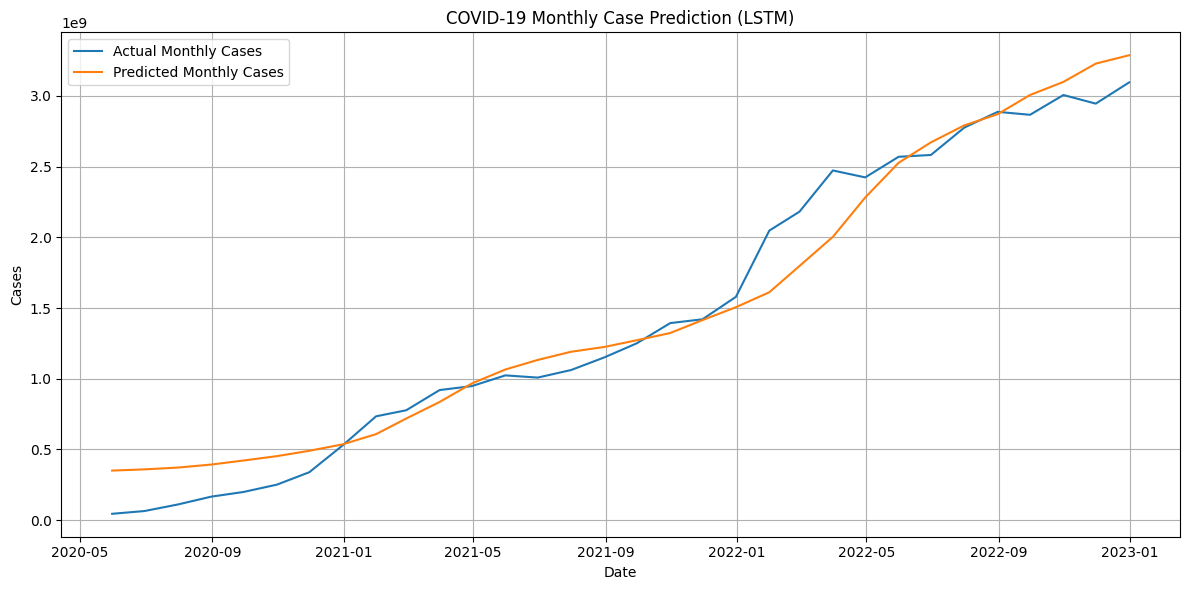

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_df['Date'][seq_length:], y_true_inverse_month, label='Actual Monthly Cases')
plt.plot(monthly_df['Date'][seq_length:], y_pred_inverse_month, label='Predicted Monthly Cases')
plt.title("COVID-19 Monthly Case Prediction (LSTM)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

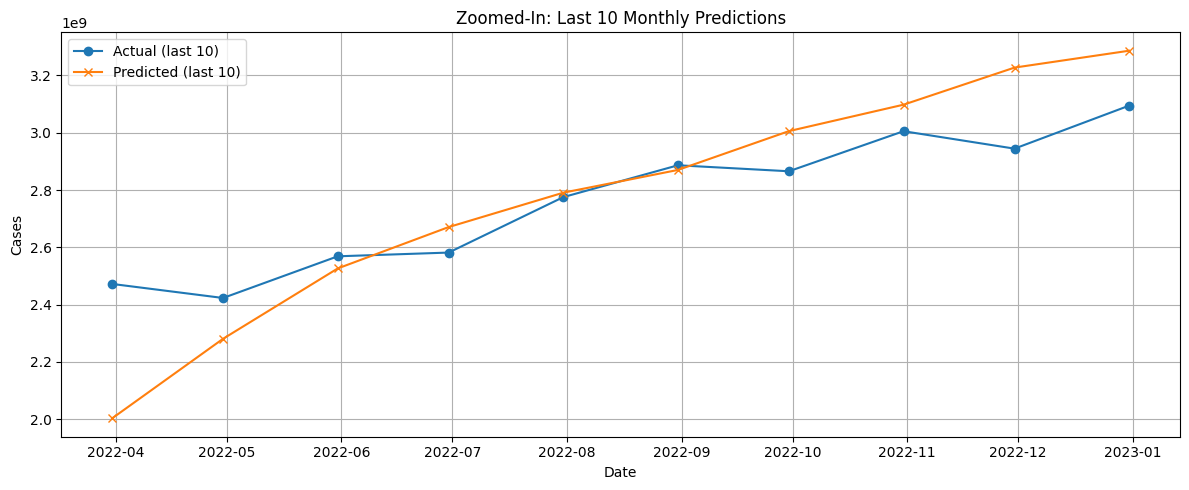

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(monthly_df['Date'][seq_length:][-10:], y_true_inverse_month[-10:], marker='o', label='Actual (last 10)')
plt.plot(monthly_df['Date'][seq_length:][-10:], y_pred_inverse_month[-10:], marker='x', label='Predicted (last 10)')
plt.title("Zoomed-In: Last 10 Monthly Predictions")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
df = pd.read_csv("cleaned_US_cases_and_deaths.csv", parse_dates=['Date'])

df = df[~df['Date'].dt.year.eq(2023)]

# group by month and sum cases
monthly_death_df = df.groupby(pd.Grouper(key='Date', freq='M'))['Cases'].sum().reset_index()

# normalize case values
scaler_month = MinMaxScaler()
deaths_scaled_month = scaler_month.fit_transform(monthly_death_df[['Cases']])

# create time series sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 4  # number of months to look back
X_month, y_month = create_sequences(deaths_scaled_month, seq_length)
X_month = X_month.reshape((X_month.shape[0], X_month.shape[1], 1))

model_month = Sequential()
model_month.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model_month.add(Dense(1))
model_month.compile(optimizer='adam', loss='mse')
model_month.fit(X_month, y_month, epochs=100, verbose=1)

y_pred_month = model_month.predict(X_month)
y_pred_inverse_month = scaler_month.inverse_transform(y_pred_month)
y_true_inverse_month = scaler_month.inverse_transform(y_month)




Epoch 1/100
1/1 [==============================] - 0s 470ms/step - loss: 0.2907
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2823
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2739
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2655
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2573
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2491
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2409
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2328
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2249
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2169
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2091
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2014
Epoch 13/100
1/1 [==============================] - 0s 2ms/

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# evaluation metrics
d_mse_m = mean_squared_error(y_true_inverse_month, y_pred_inverse_month)
d_rmse_m = np.sqrt(mse_m)
d_mae_m = mean_absolute_error(y_true_inverse_month, y_pred_inverse_month)
d_r2_m = r2_score(y_true_inverse_month, y_pred_inverse_month)
d_n_m = len(y_true_inverse_month)
d_p_m = 1
d_adjusted_r2_m = 1 - (1 - d_r2_m) * (d_n_m - 1) / (d_n_m - d_p_m - 1)

print("📅 Monthly Model Evaluation Metrics:")
print(f"📉 MSE: {d_mse_m:.2f}")
print(f"📈 RMSE: {d_rmse_m:.2f}")
print(f"📊 MAE: {d_mae_m:.2f}")
print(f"🧠 R² Score: {d_r2_m:.4f}")
print(f"🧮 Adjusted R² Score: {d_adjusted_r2_m:.4f}")

📅 Monthly Model Evaluation Metrics:
📉 MSE: 36459543278871088.00
📈 RMSE: 199865009.60
📊 MAE: 145002893.66
🧠 R² Score: 0.9648
🧮 Adjusted R² Score: 0.9637


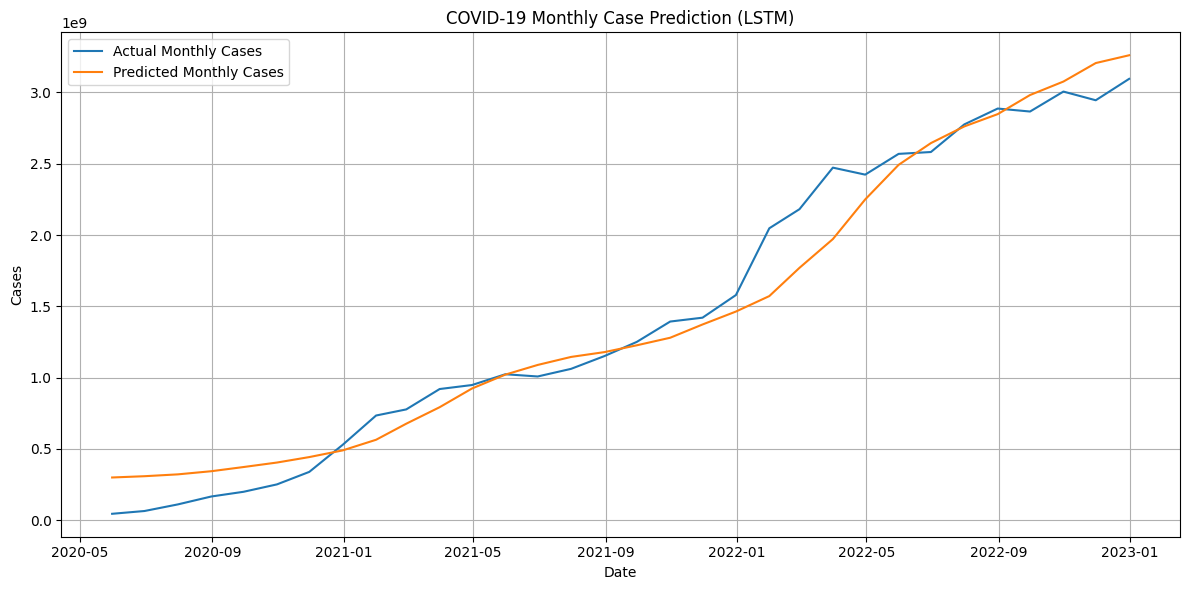

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_death_df['Date'][seq_length:], y_true_inverse_month, label='Actual Monthly Cases')
plt.plot(monthly_death_df['Date'][seq_length:], y_pred_inverse_month, label='Predicted Monthly Cases')
plt.title("COVID-19 Monthly Case Prediction (LSTM)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

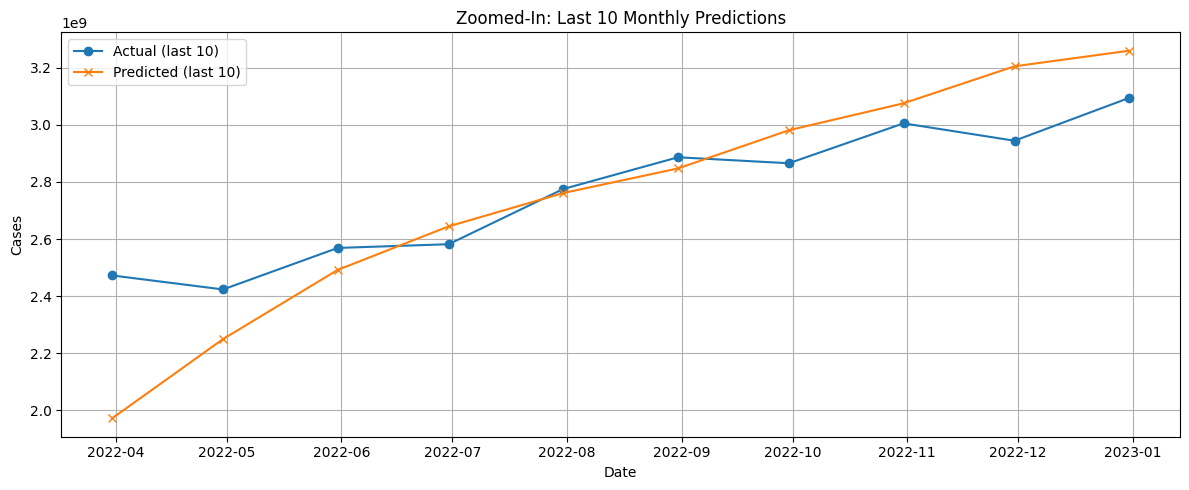

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(monthly_death_df['Date'][seq_length:][-10:], y_true_inverse_month[-10:], marker='o', label='Actual (last 10)')
plt.plot(monthly_death_df['Date'][seq_length:][-10:], y_pred_inverse_month[-10:], marker='x', label='Predicted (last 10)')
plt.title("Zoomed-In: Last 10 Monthly Predictions")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()